In [1]:
import numpy as np
import seaborn as sns
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
import matplotlib.pyplot as plt

G = 6.67e-11
c = 2.998e8
Msun = 2e30
Rsun = 7e8
year = 3600.*24.*365
kpc = 1e3*3.086e16

Let's define the LISA PSD. I'll follow Eq. 1 of [Robson et al](https://arxiv.org/pdf/1803.01944.pdf)

Text(0, 0.5, 'PSD')

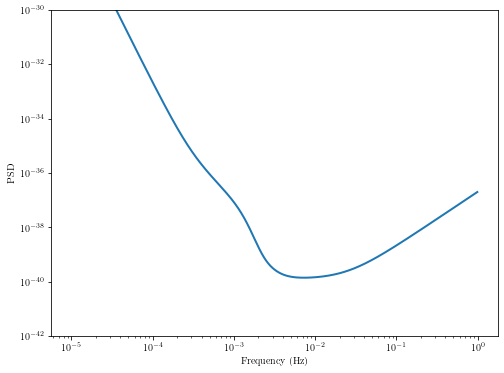

In [49]:
# https://arxiv.org/pdf/1803.01944.pdf

L_arm = 2.5e9
fref = 19.09e-3
def LISA_sensitivity(f):
    
    # Instrumental noise
    P_oms = np.power(1.5e-11,2.)*(1.+np.power(2.e-3/f,4.))
    P_acc = np.power(3.e-15,2.)*(1.+np.power(0.4e-3/f,2.))*(1.+np.power(f/8e-3,4))
    #P_n = P_oms/L_arm**2. + 2.*(1.+np.cos(f/fref)**2.)*P_acc/(np.power(2.*np.pi*f,4.)*L_arm**2.)    
    S_n = (10./(3.*L_arm*L_arm))*(P_oms + 4.*P_acc/np.power(2.*np.pi*f,4.))*(1.+(3./5.)*np.power(f/fref,2.))
    
    # Confusion noise (assume four years)
    A = 9e-45
    alpha = 0.138
    beta = -221.
    k = 521.
    gamma = 1680.
    fk = 1.13e-3
    S_conf = A*np.power(f,-7./3.)*np.exp(-f**alpha+beta*f*np.sin(k*f))*(1.+np.tanh(gamma*(fk-f)))
    
    S_n[f>=1.] = np.inf
    S_conf[f>=1.] = np.inf
    
    return S_n + S_conf

f = np.logspace(-5,0,1000)
strain_sensitivity = LISA_sensitivity(f)

fig,ax = plt.subplots(figsize=(8,6))
ax.plot(f,strain_sensitivity,lw=2)
#ax.plot(f,confusion,lw=2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-42,1e-30)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD')

Text(0, 0.5, 'PSD')

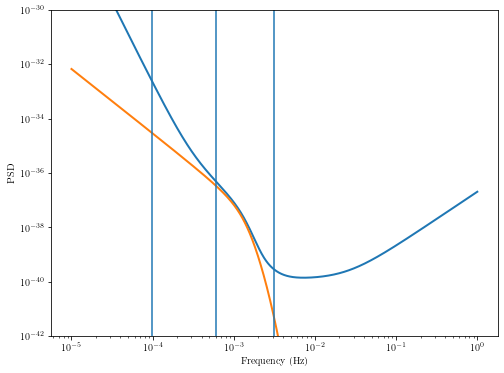

In [18]:
def f_from_a(mtot,a):
    return np.sqrt(G*mtot*Msun/(a*Rsun)**3)/(2.*np.pi)

fig,ax = plt.subplots(figsize=(8,6))
ax.plot(f,strain_sensitivity,lw=2)
ax.plot(f,confusion,lw=2)
ax.axvline(x=f_from_a(1.,1.))
ax.axvline(x=f_from_a(1.,0.3))
ax.axvline(x=f_from_a(1.,0.1))
#ax.annotate('test',xy=(1e-4,1e-40),rotate=90)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-42,1e-30)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD')

Averaging over sky position and binary inclination angles, the mean squared-SNR of a binary signal is

\begin{equation}
\langle \mathrm{SNR}\rangle^2 = \frac{16}{5} \int_0^\infty \frac{A^2(f)}{S_n(f)} df,
\end{equation}

where $A(f)$ is the amplitude of the strain signal and $S_n(f)$ is our total strain sensitivity given above. Caution -- $S_n(f)$ is *not* the PSD, but the PSD divided by the LISA transfer function.

Consider a toy binary with chirp mass $\mathcal{M}_c$ at distance $D$. Neglecting evolution, the gravitational-wave signal will have form

\begin{equation}
h(t) = \frac{4}{D} \left(\frac{G \mathcal{M}_c}{c^2} \right)^{5/3} \left(\frac{2\pi f_\mathrm{orb}}{c}\right)^{2/3} \cos(2\pi f_\mathrm{orb} t)
\end{equation}

Using Kepler's third law, this becomes

\begin{equation}
h(t) = \frac{4}{D} \frac{\eta}{a} \left(\frac{G M}{c^2}\right)^2 \cos(2\pi f_\mathrm{orb} t),
\end{equation}

where $a$ is the binary's semimajor axis and $M$ its total mass.
In the Fourier domain, we have

\begin{equation}
\boxed{A(f) = \frac{4}{D} \frac{\eta}{a} \left(\frac{G M}{c^2}\right)^2 \delta(f-2 f_\mathrm{orb})}
\end{equation}

Strictly speaking, this isn't a true delta function, but a "finite-time" delta function that evaluates to $\delta(0) = T$, the total observation time ($1/T$ is our maximum frequency resolution).
When substituting $A(f)$ into our SNR equation above, we'll let one of our two delta functions act as a finite time $delta$, giving

\begin{equation}
\begin{aligned}
\langle \mathrm{SNR}\rangle^2 &= \frac{16}{5} \left[\frac{4}{D} \frac{\eta}{a} \left(\frac{G M}{c^2}\right)^2\right]^2
        \int_0^\infty \frac{\delta^2(f-2f_\mathrm{orb})}{S_n(f)} df \\
    &= \frac{256}{5} \left(\frac{\eta}{a D}\right)^2 \left(\frac{G M}{c^2}\right)^4 T
        \int_0^\infty \frac{\delta(f-2f_\mathrm{orb})}{S_n(f)} df \\
    &= \frac{256}{5} \left(\frac{\eta}{a D}\right)^2 \left(\frac{G M}{c^2}\right)^4 \frac{T}{S_n(2f_\mathrm{orb})}
\end{aligned}
\end{equation}

In [2]:
def kepler_f(a_orb,m_comp):
    M = 2.*m_comp*Msun
    f_orb = np.sqrt(G*M/(4.*np.pi**2.*(a_orb*Rsun)**3.))
    return f_orb

def h(a_orb,m_comp,dist):
    
    # Assume equal mass
    eta = 0.25
    M = 2.*m_comp*Msun
    
    h = (4./(dist*kpc))*(eta/(a_orb*Rsun))*np.power(G*M/c**2.,2.)
    return h

def SNR(a_orb,m_comp,dist):
    
    # Assume four year observation, equal mass
    T = 1*year
    eta = 0.25
    M = 2.*m_comp*Msun
    
    # Get orbital frequency from Kepler and evaluate sensitivity curve
    f_orb = np.sqrt(G*M/(4.*np.pi**2.*(a_orb*Rsun)**3.))
    test,Sn = LISA_sensitivity(2.*f_orb)
    
    SNR2 = (256./5.)*np.power(eta/(a_orb*Rsun*dist*kpc),2.)*np.power(G*M/c**2.,4.)*T/Sn
    return np.sqrt(SNR2)

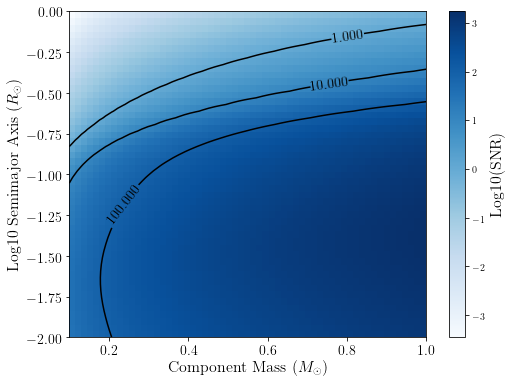

In [29]:
a_orbs = np.linspace(-2.,0,50)
m_comp = np.linspace(0.1,1,60)
M_COMP,A_ORB = np.meshgrid(m_comp,a_orbs)
rhos = SNR(10.**A_ORB,M_COMP,3)

fig,ax = plt.subplots(figsize=(8,6))
PS = ax.pcolormesh(m_comp,a_orbs,np.log10(rhos),cmap='Blues')
CS = ax.contour(m_comp,a_orbs,rhos,levels=[1,10,100],colors='black')
ax.clabel(CS, inline=1, fontsize=14)
ax.set_xlabel(r'Component Mass ($M_\odot$)',fontsize=16)
ax.set_ylabel(r'Log10 Semimajor Axis ($R_\odot$)',fontsize=16)
ax.tick_params(labelsize=14)
cb = fig.colorbar(PS)
cb.set_label(label="Log10(SNR)",fontsize=16)
plt.savefig('./SNRs.pdf')

In [56]:
def snr_from_a_adot(a0,adot):
    
    a0 = Rsun*a0
    adot = adot*Rsun/year

    # Separation (s)
    D = 3*kpc
    a_final = a0+adot*5.*year

    # Binary mass
    kg_to_sec = G/c**3.
    m = 1.*Msun

    # GW frequencies
    f0 = (1./np.pi)*np.sqrt(G*m/a0**3.)
    f_final = (1./np.pi)*np.sqrt(G*m/a_final**3.)

    # Get fourier-domain amplitudes
    fourier_freqs = np.arange(f0,f_final,(f_final-f0)/100.)
    df = f0/100.
    amp_at_f = (4./D)*np.power(G*Msun/c**2.,5./3.)*np.power(np.pi*fourier_freqs/c,2./3.)
    sep_at_f = np.power(G*Msun/(np.pi*fourier_freqs)**2,1./3.)
    fdot_at_f = -(3./(2.*np.pi))*np.sqrt(G*Msun)*np.power(sep_at_f,-5./2.)*(-0.01*Rsun/year)
    hf = amp_at_f/np.sqrt(fdot_at_f)

    PSD = LISA_sensitivity(fourier_freqs)
    rho2 = (16./5.)*np.trapz(np.power(hf,2.)/PSD,fourier_freqs)

    return np.sqrt(rho2)

def snr_from_f_fdot(f0,fdot):
    
    fdot = fdot/year
    
    # Binary mass
    m = 1.*Msun
    
    f_final = f0+fdot*5.*year
    a0 = np.power(G*m/(np.pi*f0)**2.,1./3.)
    a_final = np.power(G*m/(np.pi*f_final)**2.,1./3.)

    # Separation (s)
    D = 3*kpc

    # Get fourier-domain amplitudes
    fourier_freqs = np.arange(f0,f_final,(f_final-f0)/1000.)
    df = f0/100.
    amp_at_f = (4./D)*np.power(G*Msun/c**2.,5./3.)*np.power(np.pi*fourier_freqs/c,2./3.)
    sep_at_f = np.power(G*Msun/(np.pi*fourier_freqs)**2,1./3.)
    fdot_at_f = -(3./(2.*np.pi))*np.sqrt(G*Msun)*np.power(sep_at_f,-5./2.)*(-0.01*Rsun/year)
    hf = amp_at_f/np.sqrt(fdot_at_f)
    
    PSD = LISA_sensitivity(fourier_freqs)
    rho2 = (16./5.)*np.trapz(np.power(hf,2.)/PSD,fourier_freqs)

    return np.sqrt(rho2)

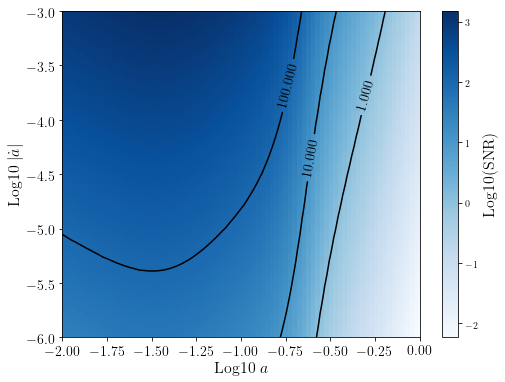

In [22]:
a_orbs = np.linspace(-2.,0,80)
adot_orbs = np.linspace(-6,-3,90)
rhos = np.zeros((a_orbs.size,adot_orbs.size))
for i in range(a_orbs.size):
    for j in range(adot_orbs.size):
        rhos[i,j] = snr_from_a_adot(10.**a_orbs[i],-10.**adot_orbs[j])

fig,ax = plt.subplots(figsize=(8,6))
PS = ax.pcolormesh(a_orbs,adot_orbs,np.log10(rhos).T,cmap='Blues')
CS = ax.contour(a_orbs,adot_orbs,rhos.T,levels=[1,10,100],colors='black')
ax.clabel(CS, inline=1, fontsize=14)
ax.set_xlabel(r'Log10 $a$',fontsize=16)
ax.set_ylabel(r'Log10 $|\dot a|$',fontsize=16)
ax.tick_params(labelsize=14)
cb = fig.colorbar(PS)
cb.set_label(label="Log10(SNR)",fontsize=16)
#plt.savefig('./SNRs.pdf')


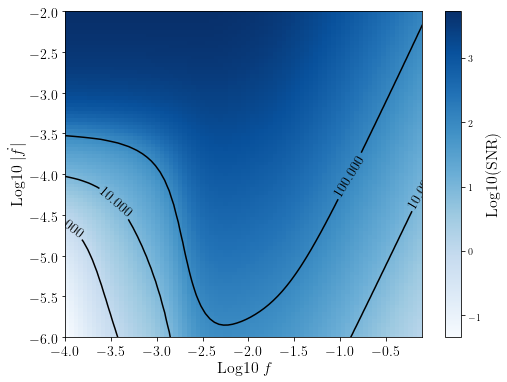

In [59]:
f_orbs = np.linspace(-4.,-0.1,80)
fdot_orbs = np.linspace(-6,-2,90)
rhos = np.zeros((f_orbs.size,fdot_orbs.size))
for i in range(f_orbs.size):
    for j in range(fdot_orbs.size):
        rhos[i,j] = snr_from_f_fdot(10.**f_orbs[i],10.**fdot_orbs[j])

fig,ax = plt.subplots(figsize=(8,6))
PS = ax.pcolormesh(f_orbs,fdot_orbs,np.log10(rhos).T,cmap='Blues')
CS = ax.contour(f_orbs,fdot_orbs,rhos.T,levels=[1,10,100],colors='black')
ax.clabel(CS, inline=1, fontsize=14)
ax.set_xlabel(r'Log10 $f$',fontsize=16)
ax.set_ylabel(r'Log10 $|\dot f|$',fontsize=16)
ax.tick_params(labelsize=14)
cb = fig.colorbar(PS)
cb.set_label(label="Log10(SNR)",fontsize=16)

# 